<a href="https://colab.research.google.com/github/KassenBoyaubay/MPA-MLF-Exercises/blob/main/Finalproject/Finalproject_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MPA-MLF, Finalproject
### *Kassen Boyaubay*

## 0. Import libraries

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# from sklearn import decomposition
# from keras import regularizers
# from sklearn import preprocessing
# from sklearn import decomposition
# from sklearn.svm import LinearSVC

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Mount Files

In [2]:
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir = os.path.join(base_dir, 'Train/Color/')
x_test_dir = os.path.join(base_dir, 'Test/Color/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data examination

### 2.1 Size of the dataset

In [3]:
print('total training images:', len(os.listdir(x_train_dir)))
print('total test images:', len(os.listdir(x_test_dir)))

total training images: 8279
total test images: 3562


### 2.2 Explore the image

Image shape:  (539, 682, 3)


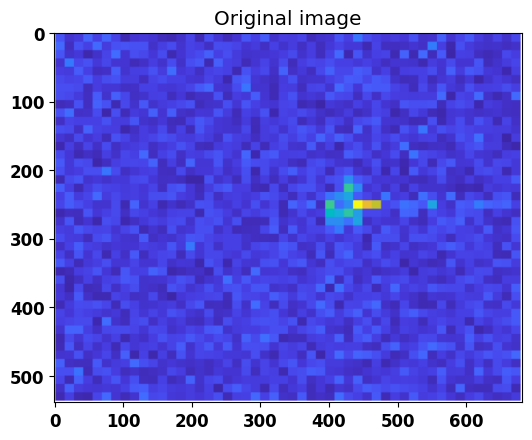

In [4]:
img = np.asarray(Image.open(x_train_dir + 'img_0.png'))

plt.imshow(img)
plt.title('Original image')

print('Image shape: ', img.shape)

### 2.3 Explore the labels

In [5]:
y_train = pd.read_csv(y_train_dir)
print(y_train.iloc[0:4])
print('y_train shape:', y_train.shape)
print('\ny_train unique values:', y_train['target'].unique())
print('labels:', len(y_train['target'].unique()))

   id  target
0   0       1
1   1       3
2   2       1
3   3       1
y_train shape: (8279, 2)

y_train unique values: [1 3 2]
labels: 3


## 3. Data preprocessing

### Compression

In [6]:
resize = (128, 128)

In [7]:
zoom = 0.2

In [8]:
(img_height, img_width, _) = img.shape
top = round(zoom*img_height/2)
left = round(zoom*img_width/2)
bottom = img_height - top
right = img_width - left

In [9]:
crop_sizes = (left, top, right, bottom)

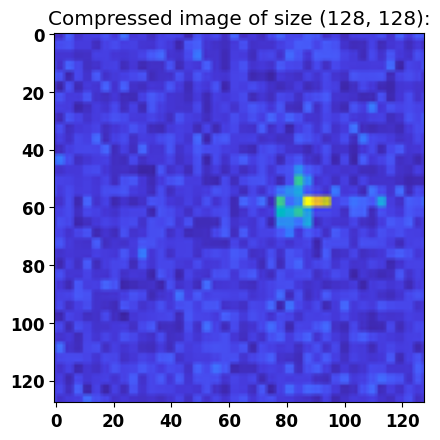

In [10]:
plt.imshow(np.asarray(Image.open(x_train_dir + 'img_0.png').crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
plt.title('Compressed image of size ' + str(resize) + ':')
print()

### 3.1 geting all sorted filenames

In [11]:
def sorting_files(st): 
    nr_part = st.split("_")[1]  # returns "number.png"
    int_part = nr_part.split(".")[0] # returns "number"
    int_part = int_part.split('(1)')[0]
    return int(int_part)
ccc = os.listdir(x_train_dir)
print(sorted(ccc, key=sorting_files))

['img_0.png', 'img_1.png', 'img_2.png', 'img_3.png', 'img_4.png', 'img_5.png', 'img_6.png', 'img_7.png', 'img_8.png', 'img_9.png', 'img_10.png', 'img_11.png', 'img_12.png', 'img_13.png', 'img_14.png', 'img_15.png', 'img_16.png', 'img_17.png', 'img_18.png', 'img_19.png', 'img_20.png', 'img_21.png', 'img_22.png', 'img_23.png', 'img_24.png', 'img_25.png', 'img_26.png', 'img_27.png', 'img_28.png', 'img_29.png', 'img_30.png', 'img_31.png', 'img_32.png', 'img_33.png', 'img_34.png', 'img_35.png', 'img_36.png', 'img_37.png', 'img_38.png', 'img_39.png', 'img_40.png', 'img_41.png', 'img_42.png', 'img_43.png', 'img_44.png', 'img_45.png', 'img_46.png', 'img_47.png', 'img_48.png', 'img_49.png', 'img_50.png', 'img_51.png', 'img_52.png', 'img_53.png', 'img_54.png', 'img_55.png', 'img_56.png', 'img_57.png', 'img_58.png', 'img_59.png', 'img_60.png', 'img_61.png', 'img_62.png', 'img_63.png', 'img_64.png', 'img_65.png', 'img_66.png', 'img_67.png', 'img_68.png', 'img_69.png', 'img_70.png', 'img_71.png', '

### 3.2 x_train preprocessing

In [12]:
x_train_dir_filenames = sorted(os.listdir(x_train_dir), key=sorting_files)
x_train = []
for filename in x_train_dir_filenames:
  x_train.append(np.asarray(Image.open(x_train_dir + filename).crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
x_train = np.array(x_train)
print(x_train.shape)

(8279, 128, 128, 3)


#### Normalize x_train

In [13]:
x_train = x_train.astype('float32')
x_train /= 255

#### Save x_train

In [14]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_train_128.npz', x_train)

#### Load x_train

In [4]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_train_128.npz')
# extract the first array
x_train = dict_data['arr_0']

### 3.3 x_test preprocessing

In [15]:
x_test_dir_filenames = sorted(os.listdir(x_test_dir), key=sorting_files)
for s in x_test_dir_filenames:
  if '(1)' in s:
    x_test_dir_filenames.remove(s)
x_test = []
for filename in x_test_dir_filenames:
  x_test.append(np.asarray(Image.open(x_test_dir + filename).crop(crop_sizes).resize(resize, Image.ANTIALIAS)))
x_test = np.array(x_test)
print(x_test.shape)

(3549, 128, 128, 3)


In [16]:
print('number of test data samples: ', len(x_test_dir_filenames))
print('first item:', x_test_dir_filenames[0])
print('last item:', x_test_dir_filenames[-1])

number of test data samples:  3549
first item: img_0.png
last item: img_3548.png


#### Normalize x_test

In [17]:
x_test = x_test.astype('float32')
x_test /= 255

#### Save x_test

In [18]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_test_128.npz', x_test)

#### Load x_test

In [5]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_test_128.npz')
# extract the first array
x_test = dict_data['arr_0']

### 3.4 y_train preprocessing

In [19]:
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
print('"target" values as array: ', y_train['target'].values)
print('one-hot encoded: \n', y_train_encoded)

"target" values as array:  [1 3 1 ... 2 1 2]
one-hot encoded: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


### 3.5 train test split

In [20]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train_encoded, test_size=0.2)

## 4. CNN model

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from numpy import load
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir = os.path.join(base_dir, 'Train/Color/')
x_test_dir = os.path.join(base_dir, 'Test/Color/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')
dict_data = load('/content/drive/MyDrive/x_train_128.npz')
x_train = dict_data['arr_0']
dict_data = load('/content/drive/MyDrive/x_test_128.npz')
x_test = dict_data['arr_0']
y_train = pd.read_csv(y_train_dir)
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train_encoded, test_size=0.2)
resize = (128, 128)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4.1 Build CNN model

In [6]:
input_shape = resize + (3, )

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
     
        # layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),    
        # # layers.BatchNormalization(),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        # layers.Dropout(0.2),
     
        # layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        # # layers.BatchNormalization(),
        # layers.MaxPooling2D(pool_size=(2, 2)),                                      
        # layers.Dropout(0.2),
     
        layers.Flatten(),
     
        layers.Dense(512, activation="relu"),
        # layers.BatchNormalization(),
        layers.Dropout(0.2),
     
        layers.Dense(256, activation="gelu"),
        # # layers.BatchNormalization(),
        layers.Dropout(0.2),
     
        # layers.Dense(128, activation="gelu"),
        # layers.BatchNormalization(),
        # layers.Dropout(0.2),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               65028608  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

### 4.2 Train CNN model

In [3]:
callback = EarlyStopping(
          # Stop training when `val_loss` is no longer improving
          monitor='val_loss',
          # "no longer improving" being defined as "no better than 1e-2 less"
          min_delta=1e-3,
          # "no longer improving" being further defined as "for at least 2 epochs"
          patience=25,
          verbose=1)

class weights

In [ ]:
y_integers = np.argmax(y_train_split, axis=1)
class_weights = class_weight.compute_class_weight(
                                                    class_weight = "balanced",
                                                    classes=np.unique(y_integers),
                                                    y = y_integers
                                                  )
d_class_weights = dict(enumerate(class_weights))

In [4]:
batch_size = 64
epochs = 30

optimizer = Adam(
    learning_rate=0.001,
)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=2, callbacks=[callback])

Epoch 1/30
83/83 - 7s - loss: 2.1355 - accuracy: 0.5177 - val_loss: 0.6230 - val_accuracy: 0.7374 - 7s/epoch - 86ms/step
Epoch 2/30
83/83 - 3s - loss: 0.5398 - accuracy: 0.7794 - val_loss: 0.4381 - val_accuracy: 0.8377 - 3s/epoch - 38ms/step
Epoch 3/30
83/83 - 3s - loss: 0.4223 - accuracy: 0.8356 - val_loss: 0.3707 - val_accuracy: 0.8664 - 3s/epoch - 39ms/step
Epoch 4/30
83/83 - 3s - loss: 0.3359 - accuracy: 0.8767 - val_loss: 0.2674 - val_accuracy: 0.8974 - 3s/epoch - 39ms/step
Epoch 5/30
83/83 - 3s - loss: 0.2538 - accuracy: 0.9083 - val_loss: 0.2138 - val_accuracy: 0.9177 - 3s/epoch - 41ms/step
Epoch 6/30
83/83 - 3s - loss: 0.2045 - accuracy: 0.9296 - val_loss: 0.2166 - val_accuracy: 0.9177 - 3s/epoch - 38ms/step
Epoch 7/30
83/83 - 3s - loss: 0.1697 - accuracy: 0.9405 - val_loss: 0.1735 - val_accuracy: 0.9343 - 3s/epoch - 39ms/step
Epoch 8/30
83/83 - 3s - loss: 0.1348 - accuracy: 0.9530 - val_loss: 0.1292 - val_accuracy: 0.9570 - 3s/epoch - 39ms/step
Epoch 9/30
83/83 - 3s - loss: 0.

### 4.3 Evaluate trained CNN model

In [5]:
loss, accuracy = model.evaluate(x_test_split, y_test_split, batch_size=1)
print('Accuracy: {:.2f}'.format(accuracy*100))
print('Loss: {:.2f}'.format(loss))

1656/1656 [==============================] - 6s 4ms/step - loss: 0.1083 - accuracy: 0.9680
Accuracy: 96.80
Loss: 0.11


Text(0, 0.5, 'loss')

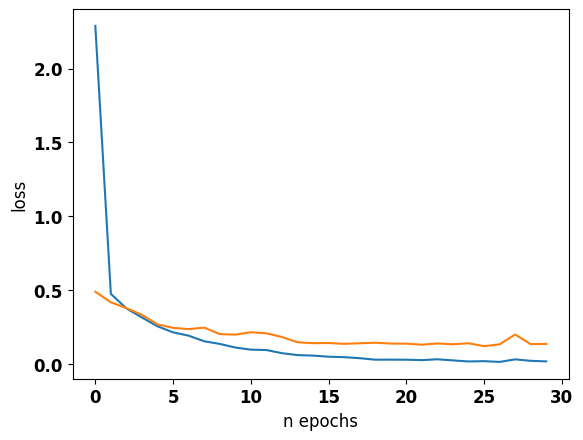

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

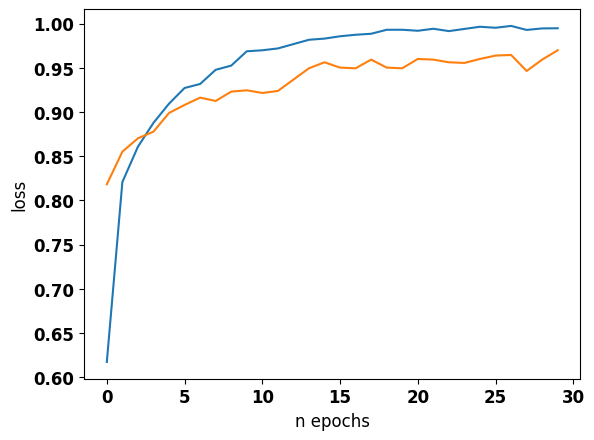

In [26]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

## 5. Model prediction

In [27]:
y_pred_enc = model.predict(x_test)

111/111 [==============================] - 1s 6ms/step


## 6. Export to CSV

In [29]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [30]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

In [31]:
y_pred_postpr.to_csv('/content/drive/MyDrive/y_pred_mlp.csv', index=False)